In [14]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('animation', html='jshtml')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams["font.size"] = "12"
plt.rcParams['mathtext.fontset'] = 'cm'

In [15]:
## SUMMARISING FUNCTIONS DEFINED

# Define colours
col = ['cyan', 'darkturquoise', 'mediumorchid', 'darkorchid']

## Define the two rhombuses of P3
def Large_rhomb(x,y):
    # Give x and y which corresponds to the coordinates of the left most vertex

    # Define angles
    small_angle = 72 * (np.pi/180)
    large_angle = 108 * (np.pi/180)
    
    # Define the largest diagonal. This is the diagonal along which the Robinson triangle decomposition is made
    B_L = (1 + np.sqrt(5))/(2)

    # Define all four vertex coordinates
    f = [(x, y), (x + np.cos(small_angle/2), y + np.sin(small_angle/2)), (x + B_L, y), (x + np.cos(small_angle/2) , y - np.sin(small_angle/2))]

    xs = [x, x+np.cos(small_angle/2), x+B_L, x+np.cos(small_angle/2)]
    ys = [y, y+np.sin(small_angle/2), y, y-np.sin(small_angle/2)]
    return xs, ys
    
def Small_rhomb(x,y):
    # Give x and y which corresponds to the coordinates of the left most vertex

    # Define angles
    small_angle = 36 * (np.pi/180)
    large_angle = 144 * (np.pi/180)
    
    # Define the largest diagonal. This is the diagonal along which the Robinson triangle decomposition is made
    B_S = (np.sqrt(5) - 1)/(2)

    # Define all four vertex coordinates

    xs = [x, x+np.cos(small_angle/2), x+2*np.cos(small_angle/2), x+np.cos(small_angle/2)]
    ys = [y, y + (1/2)*B_S, y, y - (1/2)*B_S]
    
    return xs, ys



## Define three operators for manipulating coordinates. Note the translation operator takes a vector directly, i.e. it's not used in matrix multiplication
def Rotation(angle):
    phi = angle * (np.pi/180)
    operator = np.array([[np.cos(phi), -np.sin(phi)],[np.sin(phi), np.cos(phi)]])
    return operator

def Scaling(scale, Samescale= True):
    if Samescale == True:
        operator = np.array([[scale, 0],[0, scale]])
    elif Samescale == False:
        operator = np.array([[scale[0], 0],[0, scale[1]]])
    return operator

def Translation(vector, coordinate):
    operator = vector + np.array([coordinate[0], coordinate[1]])
    return operator

# For calculating a unit vector of any given vector
def unit_vector(vector):
    unit_vector = vector/(np.linalg.norm(vector))
    return unit_vector

# For calculating angle between vectors
def angle_between(v1, v2):
    u_v1 = unit_vector(v1)
    u_v2 = unit_vector(v2)
    dot_product = np.dot(u_v1, u_v2)
    # To fix parallel and antiparallel cases use np.clip
    # See more on https://numpy.org/doc/stable/reference/generated/numpy.clip.html - last checked 01-02-2023
    # Calculate angle
    theta = np.arccos(np.clip(dot_product, -1.0, 1.0)) * (180/np.pi)
    return theta



# Define subvision of a P tile located in the origin, of an n'th interaction
def P_sub(vector, trans_vector, rotation_angle, n= 1):
    # The scaling for this is now straight up phi/1 = phi as opposed to the 1/phi from large rhomb
    phi = (np.sqrt(5) - 1)/(2)

    theta = 108

    tmp_scale = [np.matmul(Scaling(n*phi),x) for x in vector]
    tmp_rot = [np.matmul(Rotation(theta),x) for x in tmp_scale]
    tmp_trans = [Translation(x, (vector[2])) for x in tmp_rot]

    tmp_rerot = [np.matmul(Rotation(rotation_angle),x) for x in tmp_trans]
    tmp_retrans = [Translation(x, (trans_vector)) for x in tmp_rerot]

    # Create the two new triangles by using new points arising from final manipulation
    Sub_P = tmp_retrans
    Sub_Qm = np.stack((Translation(vector[0],(trans_vector)), tmp_retrans[1], tmp_retrans[0]), axis=0)

    return Sub_P, Sub_Qm

# Define subvision of a Pm tile located in the origin, of an n'th interaction
def Pm_sub(vector, trans_vector, rotation_angle, n= 1):
    # The scaling for this is now straight up phi/1 = phi as opposed to the 1/phi from large rhomb
    phi = (np.sqrt(5) - 1)/(2)

    theta = 108

    tmp_scale = [np.matmul(Scaling(n*phi),x) for x in vector]
    tmp_rot = [np.matmul(Rotation(360 - theta),x) for x in tmp_scale]
    tmp_trans = [Translation(x, (vector[1])) for x in tmp_rot]

    tmp_rerot = [np.matmul(Rotation(rotation_angle),x) for x in tmp_trans]
    tmp_retrans = [Translation(x, (trans_vector)) for x in tmp_rerot]

    # Create the two new triangles by using new points arising from final manipulation
    Sub_Pm = tmp_retrans
    Sub_Q = np.stack((tmp_retrans[0], tmp_retrans[2], Translation(vector[0],trans_vector)), axis=0)

    return Sub_Pm, Sub_Q

# Define subvision of a Qm tile located in the origin, of an n'th interaction
def Qm_sub(vector, trans_vector, rotation_angle, n= 1):
    # The scaling for this is now straight up phi/1 = phi as opposed to the 1/phi from large rhomb
    phi = (np.sqrt(5) + 1)/(2)

    theta = 144

    # Define a temporary building block of subdivided Q and Qm
    tmp_scale_block = [np.matmul(Scaling(1/phi),x) for x in vector]

    # The subdivided Q can be translated by differene of rightmost vertex in the triangle. This is in the subdivided and rotated Qm
    # Thus we can define a translation vector
    trns_vct = vector[2] - tmp_scale_block[2]

    tmp_Q_trans = [Translation(x,(trns_vct)) for x in tmp_scale_block]

    tmp_Qm_rot = [np.matmul(Rotation(216),x) for x in tmp_scale_block]
    tmp_Qm_trans = [Translation(x, ((-1)*tmp_Qm_rot[2])) for x in tmp_Qm_rot]

    # Pick anchor point for small triangle generation and well generate through translation and rotation
    overlap_point = tmp_Q_trans[0]


    # Combine new points from existing. We choose points such that the new conform to 1st being in the left vertex, the 2nd being clockwise the next upcoming and so on for the 3rd
    tmp_Pm = [overlap_point, tmp_Qm_trans[0], tmp_Q_trans[1]]

    # Now we rotate the back to the original rotation angle
    tmp_Q_rerot = [np.matmul(Rotation(rotation_angle),x) for x in tmp_Q_trans]
    tmp_Qm_rerot = [np.matmul(Rotation(rotation_angle),x) for x in tmp_Qm_trans]
    tmp_Pm_rerot = [np.matmul(Rotation(rotation_angle),x) for x in tmp_Pm]

    # Move temp figures
    tmp_Q_retrans = [Translation(x, (trans_vector)) for x in tmp_Q_rerot]
    tmp_Qm_retrans = [Translation(x, (trans_vector)) for x in tmp_Qm_rerot]
    tmp_Pm_retrans = [Translation(x, (trans_vector)) for x in tmp_Pm_rerot]

    # Create the two new triangles by using new points arising from final manipulation
    Sub_Q = tmp_Q_retrans
    Sub_Qm = tmp_Qm_retrans
    Sub_Pm = tmp_Pm_retrans
    return Sub_Pm, Sub_Q, Sub_Qm

# Define subvision of a Q tile located in the origin, of an n'th interation
def Q_sub(vector, trans_vector, rotation_angle, n= 1):
    # The scaling for this is now straight up phi/1 = phi as opposed to the 1/phi from large rhomb
    phi = (np.sqrt(5) + 1)/(2)

    theta = 144

    # Define a temporary building block of subdivided Q and Qm, though it now also serves as subdivided Qm in Q
    tmp_Qm = [np.matmul(Scaling(1/phi),x) for x in vector]

    tmp_Q_rot = [np.matmul(Rotation(144),x) for x in tmp_Qm]
    tmp_Q_trans = [Translation(x, ((-1)*tmp_Q_rot[1] + tmp_Qm[2])) for x in tmp_Q_rot]

    # Pick anchor point for small triangle generation and well generate through translation and rotation
    overlap_point = tmp_Qm[2]


    # Combine new points from existing. We choose points such that the new conform to 1st being in the left vertex, the 2nd being clockwise the next upcoming and so on for the 3rd
    tmp_Pm = [overlap_point, tmp_Qm[1], tmp_Q_trans[2]]

    # Now we rotate the back to the original rotation angle
    tmp_Q_rerot = [np.matmul(Rotation(rotation_angle),x) for x in tmp_Q_trans]
    tmp_Qm_rerot = [np.matmul(Rotation(rotation_angle),x) for x in tmp_Qm]
    tmp_Pm_rerot = [np.matmul(Rotation(rotation_angle),x) for x in tmp_Pm]

    # Move temp figures
    tmp_Q_retrans = [Translation(x, (trans_vector)) for x in tmp_Q_rerot]
    tmp_Qm_retrans = [Translation(x, (trans_vector)) for x in tmp_Qm_rerot]
    tmp_Pm_retrans = [Translation(x, (trans_vector)) for x in tmp_Pm_rerot]

    # Create the two new triangles by using new points arising from final manipulation
    Sub_Q = tmp_Q_retrans
    Sub_Qm = tmp_Qm_retrans
    Sub_Pm = tmp_Pm_retrans
    return Sub_Pm, Sub_Q, Sub_Qm

## Define operations to take an arbitrary triangle and subdivide it into predefined triangles

# Define the Small Rhombs triangles as left_RT := P and right_RT := P'. Similar for Large Rhombs Top_RT := Q and Bottom_RT := Q'


# Define the subdivision of a P
def Subdivision_P(list_of_vectors):
    i = list_of_vectors
    # First we translate the vectors from an arbitrary point in the plane back to the origin
    # Identify using the anchor point the needed translation
    anchor_point = i[0]
    # Now translate the points to the origin by Translate call
    tmp_1 = [Translation(x, (-1)*anchor_point) for x in i]

    # Now check angle of relative to the x-axis, we check non anchor points!
    p1_theta = np.arctan2(tmp_1[1][1],tmp_1[1][0]) * (180/np.pi)

    # We want to rotate such that the top vector is 18 degrees above x-axis
    correction_theta = 378 - p1_theta
    back_theta = p1_theta - 18
    tmp_1 = [np.matmul(Rotation(correction_theta),x) for x in tmp_1]
    Sub_P, Sub_Qm = P_sub(tmp_1, trans_vector= anchor_point, rotation_angle= back_theta)
    colours = [col[0],col[3]]

    # Combine a colour with set of points and set as output
    P = [Sub_P, colours[0]] 
    Qm = [Sub_Qm, colours[1]]   

    return P, Qm

# Define the subdivision of a Pm
def Subdivision_Pm(list_of_vectors):
    i = list_of_vectors
    # First we translate the vectors from an arbitrary point in the plane back to the origin
    # Identify using the anchor point the needed translation
    anchor_point = i[0]
    # Now translate the points to the origin by Translate call
    tmp_1 = [Translation(x, (-1)*anchor_point) for x in i]


    # Now check angle of relative to the x-axis, we check non anchor points!
    p1_theta = np.arctan2(tmp_1[1][1],tmp_1[1][0]) * (180/np.pi)

    # We want to rotate such that the top vector is 18 degrees above x-axis
    correction_theta = 378 - p1_theta
    back_theta = p1_theta - 18
    tmp_1 = [np.matmul(Rotation(correction_theta),x) for x in tmp_1]
    Sub_Pm, Sub_Q = Pm_sub(tmp_1, trans_vector= anchor_point, rotation_angle= back_theta)

    colours = [col[1],col[2]]
    # Combine a colour with set of points and set as output
    Pm = [Sub_Pm, colours[0]] 
    Q = [Sub_Q, colours[1]]   

    return Pm, Q

# Define subdivision of a Qm
def Subdivision_Qm(list_of_vectors):
    i = list_of_vectors
    # First we translate the vectors from an arbitrary point in the plane back to the origin
    # Identify using the anchor point the needed translation
    anchor_point = i[0]
    # Now translate the points to the origin by Translate call
    tmp_1 = [Translation(x, (-1)*anchor_point) for x in i]

    # Now check angle of relative to the x-axis, we check non anchor points!
    p1_theta = np.arctan2(tmp_1[1][1],tmp_1[1][0]) * (180/np.pi)

    # We want to rotate such that the top vector is 36 degrees above x-axis
    correction_theta = 396 - p1_theta
    back_theta = p1_theta - 36
    tmp_1 = [np.matmul(Rotation(correction_theta),x) for x in tmp_1]
    Sub_Pm, Sub_Q, Sub_Qm = Qm_sub(tmp_1, trans_vector= anchor_point, rotation_angle= back_theta)
    
    colours = [col[1], col[2], col[3]]
    
    Pm = [Sub_Pm, colours[0]]
    Q = [Sub_Q, colours[1]]
    Qm = [Sub_Qm, colours[2]]

    return Pm, Q, Qm

# Define subdivision of a Q
def Subdivision_Q(list_of_vectors):
    i = list_of_vectors
    # First we translate the vectors from an arbitrary point in the plane back to the origin
    # Identify using the anchor point the needed translation
    anchor_point = i[0]
    # Now translate the points to the origin by Translate call
    tmp_1 = [Translation(x, (-1)*anchor_point) for x in i]

    # Now check angle of relative to the x-axis, we check non anchor points!
    p1_theta = np.arctan2(tmp_1[1][1],tmp_1[1][0]) * (180/np.pi)
    

    # We want to rotate such that the top vector is 36 degrees above x-axis
    correction_theta = 396 - p1_theta
    back_theta = p1_theta - 36
    tmp_1 = [np.matmul(Rotation(correction_theta),x) for x in tmp_1]
    Sub_P, Sub_Q, Sub_Qm = Q_sub(tmp_1, trans_vector= anchor_point, rotation_angle= back_theta)
    Points = [Sub_P, Sub_Q, Sub_Qm]
    colours = [col[0], col[2], col[3]]
    
    P = [Sub_P, colours[0]]
    Q = [Sub_Q, colours[1]]
    Qm = [Sub_Qm, colours[2]]
    return P, Q, Qm

# Given a tuple this function finds the decomposition and records its positions and colours
def decomposition(tuple):
    # Define empty lists of output to fill out as we go thorugh elements
    out_point = []
    out_colour = []
    # Check the ingoing colour of a to be subdivided triangle
    if tuple[1] == col[0]:
        P, Qm = Subdivision_P(tuple[0])
        list = [P, Qm]
        out_point = [x for x,y in list]
        out_colour = [y for x,y in list]

    elif tuple[1] == col[1]:
        Pm, Q = Subdivision_Pm(tuple[0])
        list = [Pm, Q]
        out_point = [x for x,y in list]
        out_colour = [y for x,y in list]

    elif tuple[1] == col[2]:
        P, Q, Qm = Subdivision_Q(tuple[0])
        list = [P, Q, Qm]
        out_point = [x for x,y in list]
        out_colour = [y for x,y in list]

    elif tuple[1] == col[3]:
        Pm, Q, Qm = Subdivision_Qm(tuple[0])
        list = [Pm, Q, Qm]
        out_point = [x for x,y in list]
        out_colour = [y for x,y in list]

    output_tuple = [[x,y] for x,y in zip(out_point,out_colour)]

    return output_tuple
   

# Define functions for extract xs and ys of each coordinate set of the complete decomp.
# Functionally they are identical, hence comments are only attached to one
def xtractor(input_list, Plotting= False):
    if Plotting == False:
        # By slicing the array in this way we get the xs of each triangle grouped in tuples
        xs_of_arrays = np.array(input_list)[:,:,0]
        # Due to the output above we flatten and return a list of xs
        xs = [x for peeled_list in xs_of_arrays for x in peeled_list]
        return xs
    elif Plotting == True:
        xs = np.array(input_list)[:,:,0]
        return xs

def ytractor(input_list, Plotting= False):
    if Plotting == False:
        ys_of_arrays = np.array(input_list)[:,:,1]
        ys = [x for peeled_list in ys_of_arrays for x in peeled_list]
        return ys
    elif Plotting == True:
        ys = np.array(input_list)[:,:,1]
        return ys


def xy_separator(input_list):
    xs = np.array(input_list)[:,0]
    ys = np.array(input_list)[:,1]
    return xs, ys

# Define a recursive function which identifies triangles based on assigned colour and decomposes it according to previously specified decomposition functions
def recur_decomp(input, stop):
    # Output section. Notice how we output coordinates and colours separate now
    if stop == 0:
        return print("I cannot do no decomposition")
    
    if stop == 1:
        tmp_out = list(map(decomposition, input))
        out_flat = [x for peeled_list in tmp_out for x in peeled_list]
        coordinates = [x for x,y in out_flat]
        colours = [y for x,y in out_flat]
        return coordinates, colours
    # Recursive section
    else:
        tmp_out = list(map(decomposition, input))
        out_flat = [x for peeled_list in tmp_out for x in peeled_list]
        return recur_decomp(out_flat, stop - 1)


# Duplicate remover takes in a list of coordinates which make up the final decomposition
def duplicate_remover(list_of_points, i=0):

    # Define a stop parameter which is dependent of the incoming list, since this changes lengths with every iteration
    stop = len(list_of_points)

    # Indices also change per interation though is constantly ticking one up since we always leave in place the "original" point
    # The original point refers to the first instance of a coordinate set being used in the final decomposition
    indices = range(len(list_of_points))

    # End parameter and exiting
    if stop <= i:
        return list_of_points

    # Primary loop
    else:
        # Hitlist contains the norm to every point, if we find one with norm less than a predetermined threshold it can be target for deletion
        hitlist = [np.linalg.norm(np.array(list_of_points[i]) - np.array(x)) for x in list_of_points]
    
        # Deciding threshold
        threshold = 1*10**(-3)

    	# Indices are targeted with the following list comprehension
        targets = [j for j in indices if hitlist[j] < threshold and j > i]

        # New index list by comparison
        surviving_indices = list(set(indices) - set(targets))

        # New list with remaining indices
        reduced_list = [list_of_points[j] for j in surviving_indices]

        # Run again
        return duplicate_remover(reduced_list, i= i + 1)

0.09016994374947428


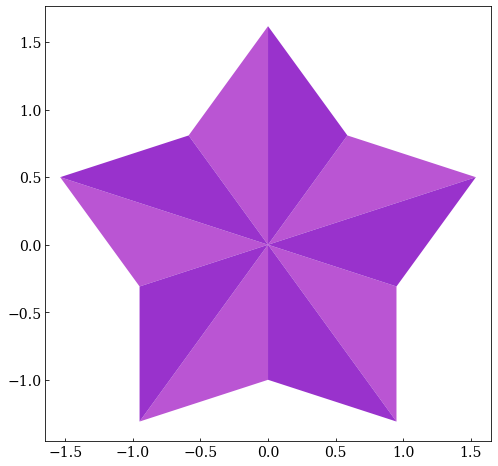

In [16]:
## Calculation cell

# Define a small rhomb
xs_large, ys_large = np.matmul(Rotation(90),np.array(Large_rhomb(0,0))).tolist()
fig, ax = plt.subplots(figsize=(8,8))
ax.axis('equal')
# Define triangles P and P':= Pm
xs_P_up = xs_large[:3]
ys_P_up = ys_large[:3]

xs_P_down = xs_large[2:4] + [xs_large[0]]
ys_P_down = ys_large[2:4] + [ys_large[0]]
# We let the left most point be the anchor point
P_up = np.array([(x,y) for x,y in zip(xs_P_up, ys_P_up)])
P_down = np.array([(x,y) for x,y in zip(xs_P_down, ys_P_down)])

Ps_tmp_up = [[np.matmul(Rotation(x),i) for i in P_up] for x in [72*0, 72*1, 72*2, 72*3, 72*4]]
Ps_tmp_down = [[np.matmul(Rotation(x),i) for i in P_down] for x in [72*0, 72*1, 72*2, 72*3, 72*4]]
Ps_up = [[x, col[2]] for x in Ps_tmp_up]
Ps_down = [[x, col[3]] for x in Ps_tmp_down]

Ps = Ps_up + Ps_down

for i in Ps:
    xs = [x for x,y in i[0]]
    ys = [y for x,y in i[0]]
    ax.fill(xs,ys, i[1])

decomp_number = 5
coors, cols = recur_decomp(Ps, decomp_number)
list_of_xs = xtractor(coors, Plotting= True)
list_of_ys = ytractor(coors, Plotting= True)

# We know from online resource that two arrows always have the same length which is the number of decompositions, phi, multiplied with the original length of a 2 arrow
# A 2 arrow corresponds to the side of either P or P' but after decomposition it is placed at the previous base
# This we now to be
P_base = (1/2)*(np.sqrt(5) - 1)

Side_decomp = P_base**(decomp_number)
print(Side_decomp)

In [17]:
xs_test = xtractor(coors)
ys_test = ytractor(coors)
point_choice = 34
all_points = [[x,y] for x, y in zip(xs_test, ys_test)]

test_points = duplicate_remover(all_points)

red_xs, red_ys = xy_separator(test_points)

# Define function for finding possible jumps to other states of a particle

# Check if the particle can make a jump to a neighbouring state.
# The state must be separated by a distance of the decomposed rhombus side length

def jump_finder(input_list):
    # Define empty possible jumps
    total_jumps = []
    jump_indices = []
    for i in input_list:
        # Calculate every jump for every point
        jumps = [x for x in input_list if  Side_decomp - 1*10**(-(decomp_number + 1)) < np.linalg.norm( np.array(i) - np.array(x) ) < Side_decomp + 1*10**(-(decomp_number + 1))]
        # Find index of site to which we may jump
        indices = [j for j in range(len(input_list)) for y in jumps if input_list[j] == y]
        # Append to main lists
        total_jumps.append(jumps)
        jump_indices.append(indices)
    return total_jumps, jump_indices

In [18]:
total_jumps, jump_indices = jump_finder(test_points)

x_sides = [x for x,y in total_jumps[point_choice]]
y_sides = [y for x,y in total_jumps[point_choice]]

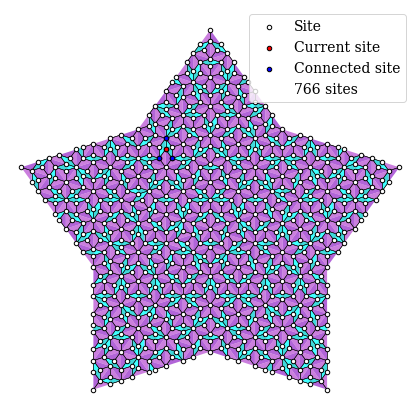

In [19]:
# Drawing of an illustration for construction explanation

fig, ax = plt.subplots(figsize=(6,6))

for i,j,k in zip(cols,list_of_xs,list_of_ys):
    xs = j
    ys = k
    ax.fill(xs, ys, i, alpha= 0.75)

for i,j in zip(test_points,total_jumps):
    xs = [x for x,y in j]
    ys = [y for x,y in j]
    for l,k in zip(xs,ys):
        ax.plot([i[0],l], [i[1],k], color= 'k', zorder= 1, linewidth= 0.5)

marker_size = 20
point_of_choice = 2

x_sides_h = [x for x,y in total_jumps[point_of_choice]]
y_sides_h = [y for x,y in total_jumps[point_of_choice]]

number_of_sites = len(red_xs)

ax.scatter(x= red_xs, y= red_ys, s= marker_size, facecolor= 'w', edgecolor= 'k', label= 'Site')
ax.scatter(x= test_points[point_of_choice][0], y= test_points[point_of_choice][1], s= marker_size, facecolor= 'r', edgecolor= 'k', label= 'Current site')
ax.scatter(x= x_sides_h, y= y_sides_h, s= marker_size, facecolor= 'b', edgecolor= 'k', label= 'Connected site')
ax.scatter(x= [], y= [], marker= '', label= f'{number_of_sites} sites')

ax.axis('equal')
ax.legend(loc= 1)
ax.axis('off')
plt.tight_layout()
#plt.savefig('../../Illustrations/hofstadter_P3_tiling.png')

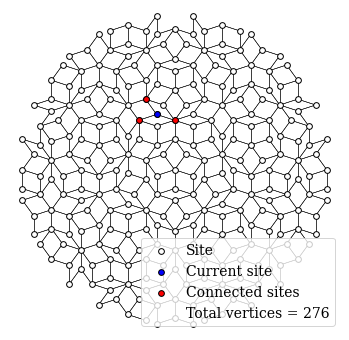

In [24]:
# Now we remove star edges for test of Bott indices
filtered_grids = [coor for coor in test_points if np.linalg.norm(coor) <= 0.75]
filtered_jump_coors, filtered_jump_indices = jump_finder(filtered_grids)

# Define figure
fig, ax = plt.subplots(figsize= (6,6))

# Plot all possible paths between vertices
for i,j in zip(filtered_grids, filtered_jump_coors):
    xs = [w[0] for w in j]
    ys = [w[1] for w in j]
    for l,k in zip(xs,ys):
        ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)


# Choose index to highlight a specific vertex and its connecting points
#ind_choice = int(len(z)*0.33)
ind_choice = 23

xs_jumps = [w[0] for w in filtered_jump_coors[ind_choice]]
ys_jumps = [w[1] for w in filtered_jump_coors[ind_choice]]

marker_size = 33

xs = [x for x,y in filtered_grids]
ys = [y for x,y in filtered_grids]

ax.scatter(x= xs, y= ys, s= marker_size, facecolor= 'w', edgecolor= 'k', label= "Site", linewidth= 1)
ax.scatter(x= filtered_grids[ind_choice][0], y= filtered_grids[ind_choice][1], s= marker_size, facecolor= 'b', edgecolor= 'k', label= "Current site", linewidth= 1)
ax.scatter(x= xs_jumps, y= ys_jumps, s= marker_size, facecolor= 'r', edgecolor= 'k', label= "Connected sites", linewidth= 1)
ax.plot([],[], linestyle= '', label= "Total vertices = {}".format(len(filtered_grids)))

ax.legend(loc= 4)

ax.axis('equal')
ax.axis('off')

plt.savefig('../../Illustrations/hofstadter_P3_tiling.png', bbox_inches= 'tight')

plt.show()

In [21]:
def Hamil_solve(grid_coor, jump_coor, jump_ind, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(grid_coor)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    l = Side_decomp
    phi = B * l**2 * np.sin( 108 * (np.pi/180))
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(grid_coor, jump_coor):
        products = [i[0]*k[1] - k[0]*i[1] for k in j]
        jump_products.append(products)
    phase_factors = []
    for x, y in zip(grid_coor, jump_products):
        phases = [(phi/(2 * l**2 * np.sin( 108 * (np.pi/180)))) * s for s in y]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_ind, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues
    eig_vals, eig_vecs = np.linalg.eigh(H)
    return eig_vals, eig_vecs

# Calculate eigenvalues for varying B field strength
#Bs = np.linspace(0,17.2961253195442,10)
max_B = (2*np.pi)/(Side_decomp**2 * np.sin(108*(np.pi/180)))
Bs = np.linspace(0, max_B, 1000)
eigvals = [Hamil_solve(filtered_grids, filtered_jump_coors, filtered_jump_indices, x)[0] for x in Bs]
# Segment the eigenvalues into proper drawable bands
dim_H = len(filtered_grids)
bands = [x for x in range(0, dim_H)]

eigs_banded = []
for i in bands:
    band = [x[i] for x in eigvals]
    eigs_banded.append(band)

print(max_B)

812.549720608777


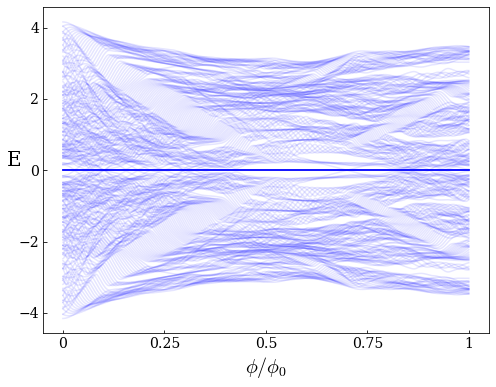

In [22]:
fig, ax = plt.subplots(figsize= (8,6))

for y in eigs_banded:
    ax.plot(Bs,y, color= 'b', alpha= 0.1)

max_B = max(Bs)
ax.set_xticks([0, 0.25*max_B, 0.5*max_B, 0.75*max_B, max_B], ['0', '0.25', '0.5', '0.75', '1'])
ax.set_xlabel(r'$\phi / \phi_0$')
ax.set_ylabel('E', rotation= 0)

#plt.savefig('../../Illustrations/Penrose_bands.png', bbox_inches= 'tight')
plt.show()

In [23]:
"""# Saving points, jump indices, and jumps
with open('../../Grids/Pe_grid.txt', 'w') as file:
    for i in filtered_grids:
        file.write(f'{i[0]},{i[1]}')
        file.write('\n')

max_length1 = max([len(x) for x in jump_indices])
with open('../../Grids/Pe_jump_indices.txt', 'w') as file:
    for i in filtered_jump_indices:
        if len(i) == max_length1:
            w = i + ['stop']
            for j in range(len(w)):
                file.write(f'{w[j]}')
                file.write(' ')
            file.write('\n')
        else:
            diff = max_length1 - len(i)
            extension = ['stop' for _ in range(0,diff + 1)]
            extended_list = i + extension
            for j in range(len(extended_list)):
                file.write(f'{extended_list[j]}')
                file.write(' ')
            file.write('\n')

max_length2 = max([len(x) for x in total_jumps])
with open('../../Grids/Pe_jump_coordinates.txt', 'w') as file:
    for i in filtered_jump_coors:
        new_list = [f'({x[0]},{x[1]})' for x in i]
        if len(new_list) == max_length2:
            new_list1 = new_list + ['stop']
            for j in range(len(new_list1)):
                file.write(f'{new_list1[j]}')
                file.write(' ')
            file.write('\n')
        else:
            diff = max_length2 - len(new_list)
            extension = ['stop' for _ in range(0,diff + 1)]
            extended_list = new_list + extension
            for j in range(len(extended_list)):
                file.write(f'{extended_list[j]}')
                file.write(' ')
            file.write('\n')"""

"# Saving points, jump indices, and jumps\nwith open('../../Grids/Pe_grid.txt', 'w') as file:\n    for i in filtered_grids:\n        file.write(f'{i[0]},{i[1]}')\n        file.write('\n')\n\nmax_length1 = max([len(x) for x in jump_indices])\nwith open('../../Grids/Pe_jump_indices.txt', 'w') as file:\n    for i in filtered_jump_indices:\n        if len(i) == max_length1:\n            w = i + ['stop']\n            for j in range(len(w)):\n                file.write(f'{w[j]}')\n                file.write(' ')\n            file.write('\n')\n        else:\n            diff = max_length1 - len(i)\n            extension = ['stop' for _ in range(0,diff + 1)]\n            extended_list = i + extension\n            for j in range(len(extended_list)):\n                file.write(f'{extended_list[j]}')\n                file.write(' ')\n            file.write('\n')\n\nmax_length2 = max([len(x) for x in total_jumps])\nwith open('../../Grids/Pe_jump_coordinates.txt', 'w') as file:\n    for i in filte